In [1]:
!pip install lime

In [2]:
pip install opencv-python

Note: you may need to restart the kernel to use updated packages.


In [3]:
#from google.colab import drive
#drive.mount('/content/drive')

In [4]:
import os
os.chdir('ECE1512_Li_Dai')  # Change the directory to torchRay-master folder

# Requirements

In [5]:
import os
import numpy as np
import pandas as pd
import requests
import scipy
import pickle
from scipy.ndimage.filters import gaussian_filter
from scipy.interpolate import interp1d
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Dense, Flatten
from keras import regularizers
import keras.backend as K
from keras.models import load_model
from tensorflow.core.util import event_pb2
from tensorflow.python.lib.io import tf_record
import sklearn.metrics as metrics
import matplotlib.pyplot as plt
import cv2
from sklearn.preprocessing import OneHotEncoder
import datetime

In [6]:
#@title MNIST-1D utils

# transformations of the templates which will make them harder to classify
def pad(x, padding):
    low, high = padding
    p = low + int(np.random.rand()*(high-low+1))
    return np.concatenate([x, np.zeros((p))])

def shear(x, scale=10):
    coeff = scale*(np.random.rand() - 0.5)
    return x - coeff*np.linspace(-0.5,.5,len(x))

def translate(x, max_translation):
    k = np.random.choice(max_translation)
    return np.concatenate([x[-k:], x[:-k]])

def corr_noise_like(x, scale):
    noise = scale * np.random.randn(*x.shape)
    return gaussian_filter(noise, 2)

def iid_noise_like(x, scale):
    noise = scale * np.random.randn(*x.shape)
    return noise

def interpolate(x, N):
    scale = np.linspace(0,1,len(x))
    new_scale = np.linspace(0,1,N)
    new_x = interp1d(scale, x, axis=0, kind='linear')(new_scale)
    return new_x

def transform(x, y, args, eps=1e-8):
    new_x = pad(x+eps, args.padding) # pad
    new_x = interpolate(new_x, args.template_len + args.padding[-1])  # dilate
    new_y = interpolate(y, args.template_len + args.padding[-1])
    new_x *= (1 + args.scale_coeff*(np.random.rand() - 0.5))  # scale
    new_x = translate(new_x, args.max_translation)  #translate
    
    # add noise
    mask = new_x != 0
    new_x = mask*new_x + (1-mask)*corr_noise_like(new_x, args.corr_noise_scale)
    new_x = new_x + iid_noise_like(new_x, args.iid_noise_scale)
    
    # shear and interpolate
    new_x = shear(new_x, args.shear_scale)
    new_x = interpolate(new_x, args.final_seq_length) # subsample
    new_y = interpolate(new_y, args.final_seq_length)
    return new_x, new_y

def get_dataset_args(as_dict=False):
    arg_dict = {'num_samples': 5000,
            'train_split': 0.8,
            'template_len': 12,
            'padding': [36,60],
            'scale_coeff': .4, 
            'max_translation': 48,
            'corr_noise_scale': 0.25,
            'iid_noise_scale': 2e-2,
            'shear_scale': 0.75,
            'shuffle_seq': False,
            'final_seq_length': 40,
            'seed': 42,
            'url': 'https://github.com/greydanus/mnist1d/raw/master/mnist1d_data.pkl'}
    return arg_dict if as_dict else ObjectView(arg_dict)


def to_pickle(thing, path): # save something
    with open(path, 'wb') as handle:
        pickle.dump(thing, handle, protocol=4)


def from_pickle(path): # load something
    thing = None
    with open(path, 'rb') as handle:
        thing = pickle.load(handle)
    return thing

class ObjectView(object):
    def __init__(self, d): self.__dict__ = d

# basic 1D templates for the 10 digits
def get_templates():
    d0 = np.asarray([5,6,6.5,6.75,7,7,7,7,6.75,6.5,6,5])
    d1 = np.asarray([5,3,3,3.4,3.8,4.2,4.6,5,5.4,5.8,5,5])
    d2 = np.asarray([5,6,6.5,6.5,6,5.25,4.75,4,3.5,3.5,4,5])
    d3 = np.asarray([5,6,6.5,6.5,6,5,5,6,6.5,6.5,6,5])
    d4 = np.asarray([5,4.4,3.8,3.2,2.6,2.6,5,5,5,5,5,5])
    d5 = np.asarray([5,3,3,3,3,5,6,6.5,6.5,6,4.5,5])
    d6 = np.asarray([5,4,3.5,3.25,3,3,3,3,3.25,3.5,4,5])
    d7 = np.asarray([5,7,7,6.6,6.2,5.8,5.4,5,4.6,4.2,5,5])
    d8 = np.asarray([5,4,3.5,3.5,4,5,5,4,3.5,3.5,4,5])
    d9 = np.asarray([5,4,3.5,3.5,4,5,5,5,5,4.7,4.3,5])
    
    x = np.stack([d0,d1,d2,d3,d4,d5,d6,d7,d8,d9])
    x -= x.mean(1,keepdims=True) # whiten
    x /= x.std(1,keepdims=True)
    x -= x[:,:1]  # signal starts and ends at 0
    
    templates = {'x': x/6., 't': np.linspace(-5, 5, len(d0))/6.,
                 'y': np.asarray([0,1,2,3,4,5,6,7,8,9])}
    return templates

def make_dataset(args=None, template=None, ):
    templates = get_templates() if template is None else template
    args = get_dataset_args() if args is None else args
    np.random.seed(args.seed) # reproducibility
    
    xs, ys = [], []
    samples_per_class = args.num_samples // len(templates['y'])
    for label_ix in range(len(templates['y'])):
        for example_ix in range(samples_per_class):
            x = templates['x'][label_ix]
            t = templates['t']
            y = templates['y'][label_ix]
            x, new_t = transform(x, t, args) # new_t transformation is same each time
            xs.append(x) ; ys.append(y)
    
    batch_shuffle = np.random.permutation(len(ys)) # shuffle batch dimension
    xs = np.stack(xs)[batch_shuffle]
    ys = np.stack(ys)[batch_shuffle]
    
    if args.shuffle_seq: # maybe shuffle the spatial dimension
        seq_shuffle = np.random.permutation(args.final_seq_length)
        xs = xs[...,seq_shuffle]
    
    new_t = new_t/xs.std()
    xs = (xs-xs.mean())/xs.std() # center the dataset & set standard deviation to 1

    # train / test split
    split_ix = int(len(ys)*args.train_split)
    dataset = {'x': xs[:split_ix], 'x_test': xs[split_ix:],
               'y': ys[:split_ix], 'y_test': ys[split_ix:],
               't':new_t, 'templates': templates}
    return dataset


In [7]:
from mnist1d_utils import *

# Dataset

In [8]:
dataset = make_dataset()

**Dataset:** A dictionary conaining 4000 train and 1000 test data.

Keys of the dictionary:

* 'x' : Training data.

* 'y' : Training labels.

* 'x_test' : Test data.

* 'y_test : Test labels.

* 't' : Mapping data points to spatial locations.

* 'templates' : The templates for the digits 0-9.

Text(0.5, 1.0, 'predicted class: 6')

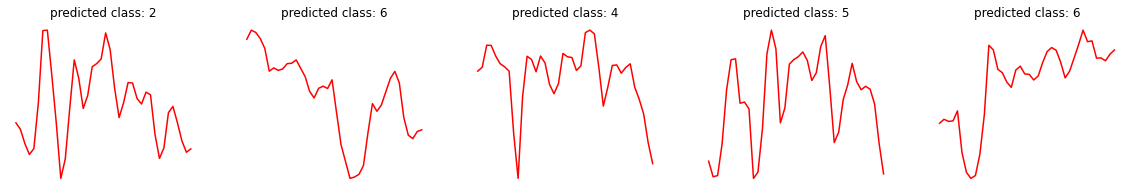

In [9]:
#@title Show some examples from the MNIST 1-D dataset

plt.figure(figsize=(20,3))

plt.subplot(151)
plt.plot(dataset['x'][0], 'r')
plt.axis('off')
plt.title('predicted class: '+str(dataset['y'][0]))

plt.subplot(152)
plt.plot(dataset['x'][1], 'r')
plt.axis('off')
plt.title('predicted class: '+str(dataset['y'][1]))

plt.subplot(153)
plt.plot(dataset['x'][2], 'r')
plt.axis('off')
plt.title('predicted class: '+str(dataset['y'][2]))

plt.subplot(154)
plt.plot(dataset['x'][3], 'r')
plt.axis('off')
plt.title('predicted class: '+str(dataset['y'][3]))

plt.subplot(155)
plt.plot(dataset['x'][4], 'r')
plt.axis('off')
plt.title('predicted class: '+str(dataset['y'][4]))

Text(0.5, 1.0, 'predicted class: 9')

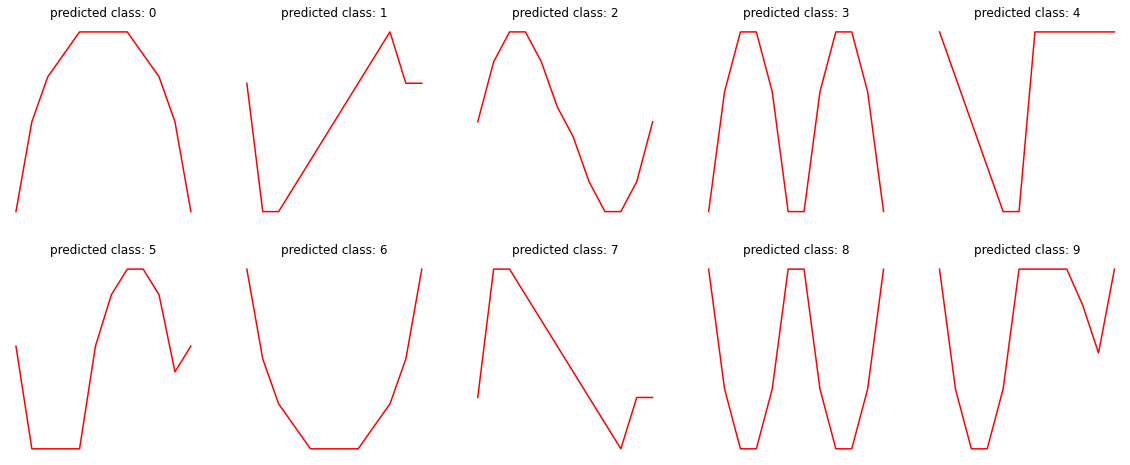

In [10]:
#@title Show the digit templates in the MNIST 1-D dataset 

plt.figure(figsize=(20,8))

plt.subplot(251)
plt.plot(dataset['templates']['x'][0], 'r')
plt.axis('off')
plt.title('predicted class: 0')

plt.subplot(252)
plt.plot(dataset['templates']['x'][1], 'r')
plt.axis('off')
plt.title('predicted class: 1')

plt.subplot(253)
plt.plot(dataset['templates']['x'][2], 'r')
plt.axis('off')
plt.title('predicted class: 2')

plt.subplot(254)
plt.plot(dataset['templates']['x'][3], 'r')
plt.axis('off')
plt.title('predicted class: 3')

plt.subplot(255)
plt.plot(dataset['templates']['x'][4], 'r')
plt.axis('off')
plt.title('predicted class: 4')

plt.subplot(256)
plt.plot(dataset['templates']['x'][5], 'r')
plt.axis('off')
plt.title('predicted class: 5')

plt.subplot(257)
plt.plot(dataset['templates']['x'][6], 'r')
plt.axis('off')
plt.title('predicted class: 6')

plt.subplot(258)
plt.plot(dataset['templates']['x'][7], 'r')
plt.axis('off')
plt.title('predicted class: 7')

plt.subplot(259)
plt.plot(dataset['templates']['x'][8], 'r')
plt.axis('off')
plt.title('predicted class: 8')

plt.subplot(2,5,10)
plt.plot(dataset['templates']['x'][9], 'r')
plt.axis('off')
plt.title('predicted class: 9')

Saving the dataset

In [11]:
f = open("MNIST1D.pkl","wb")
pickle.dump(dataset,f)
f.close()

# Model Creation

**Creating model :**

A 1-Dimensional CNN, containing 3 convolutional layers, followed by a fully-connected output layer.

In [12]:
##Task1-Question1
weight_decay = 5e-4
model = Sequential()
#Your code starts from here 
dataset['x'] = np. expand_dims(dataset['x'], 2)
model.add(Conv1D(25, 5, activation='relu', padding='same', kernel_regularizer=regularizers.l2(weight_decay),
                 bias_regularizer=regularizers.l2(weight_decay)))
model.add(Conv1D(25, 3, activation='relu', padding='same', kernel_regularizer=regularizers.l2(weight_decay),
                 bias_regularizer=regularizers.l2(weight_decay)))
model.add(Conv1D(25, 3, activation='relu', padding='same', kernel_regularizer=regularizers.l2(weight_decay),
                 bias_regularizer=regularizers.l2(weight_decay)))
model.add(Flatten())
model.add(Dense(10, activation='softmax', kernel_regularizer=regularizers.l2(weight_decay), 
                bias_regularizer=regularizers.l2(weight_decay))) #output is 10 classes
##

# Training the model

Compiling the model

Loss function: Cross-entropy

Optimizer: Stochastic Gradient Descent (SGD) (learning rate = 0.01)

Tensorboard: For recording the training procedure

In [13]:
##Task1-Question2

#Your code
#Dataset label Onehot
encoder = OneHotEncoder(sparse=False)
onehot_ytrain = encoder.fit_transform(dataset['y'].reshape(-1, 1))
onehot_ytest = encoder.fit_transform(dataset['y_test'].reshape(-1, 1))

#Compile model
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01)
loss = keras.losses.CategoricalCrossentropy()
model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

#tensorboard callback
log_dir="logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

#fit model
#model.fit(dataset['x'], onehot_ytrain, epochs=200, callbacks=[tensorboard_callback])
model.fit(dataset['x'], onehot_ytrain, epochs=200, callbacks=[tensorboard_callback])
##

Epoch 1/200
125/125 [==============================] - 1s 3ms/step - loss: 2.3224 - accuracy: 0.1303
Epoch 2/200
125/125 [==============================] - 0s 3ms/step - loss: 2.2395 - accuracy: 0.1935
Epoch 3/200
125/125 [==============================] - 0s 3ms/step - loss: 2.0346 - accuracy: 0.2222
Epoch 4/200
125/125 [==============================] - 0s 3ms/step - loss: 1.8479 - accuracy: 0.2727
Epoch 5/200
125/125 [==============================] - 0s 2ms/step - loss: 1.7603 - accuracy: 0.3033
Epoch 6/200
125/125 [==============================] - 0s 2ms/step - loss: 1.7008 - accuracy: 0.3318
Epoch 7/200
125/125 [==============================] - 0s 3ms/step - loss: 1.6423 - accuracy: 0.3580
Epoch 8/200
125/125 [==============================] - 0s 3ms/step - loss: 1.5821 - accuracy: 0.3857
Epoch 9/200
125/125 [==============================] - 0s 3ms/step - loss: 1.5250 - accuracy: 0.4128
Epoch 10/200
125/125 [==============================] - 0s 3ms/step - loss: 1.4827 - accura

125/125 [==============================] - 0s 3ms/step - loss: 0.2395 - accuracy: 0.9565
Epoch 80/200
125/125 [==============================] - 0s 3ms/step - loss: 0.2385 - accuracy: 0.9597
Epoch 81/200
125/125 [==============================] - 0s 3ms/step - loss: 0.2340 - accuracy: 0.9572
Epoch 82/200
125/125 [==============================] - 0s 3ms/step - loss: 0.2315 - accuracy: 0.9575
Epoch 83/200
125/125 [==============================] - 0s 3ms/step - loss: 0.2265 - accuracy: 0.9620
Epoch 84/200
125/125 [==============================] - 0s 3ms/step - loss: 0.2223 - accuracy: 0.9615
Epoch 85/200
125/125 [==============================] - 0s 3ms/step - loss: 0.2195 - accuracy: 0.9622
Epoch 86/200
125/125 [==============================] - 0s 3ms/step - loss: 0.2161 - accuracy: 0.9625
Epoch 87/200
125/125 [==============================] - 0s 3ms/step - loss: 0.2124 - accuracy: 0.9653
Epoch 88/200
125/125 [==============================] - 0s 3ms/step - loss: 0.2111 - accuracy: 

125/125 [==============================] - 0s 2ms/step - loss: 0.1300 - accuracy: 0.9975
Epoch 159/200
125/125 [==============================] - 0s 2ms/step - loss: 0.1295 - accuracy: 0.9977
Epoch 160/200
125/125 [==============================] - 0s 2ms/step - loss: 0.1280 - accuracy: 0.9987
Epoch 161/200
125/125 [==============================] - 0s 3ms/step - loss: 0.1286 - accuracy: 0.9985
Epoch 162/200
125/125 [==============================] - 0s 3ms/step - loss: 0.1285 - accuracy: 0.9987
Epoch 163/200
125/125 [==============================] - 0s 2ms/step - loss: 0.1274 - accuracy: 0.9977
Epoch 164/200
125/125 [==============================] - 0s 2ms/step - loss: 0.1281 - accuracy: 0.9980
Epoch 165/200
125/125 [==============================] - 0s 2ms/step - loss: 0.1275 - accuracy: 0.9985
Epoch 166/200
125/125 [==============================] - 0s 2ms/step - loss: 0.1271 - accuracy: 0.9983
Epoch 167/200
125/125 [==============================] - 0s 2ms/step - loss: 0.1263 - a

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (32, 40, 25)              150       
                                                                 
 conv1d_1 (Conv1D)           (32, 40, 25)              1900      
                                                                 
 conv1d_2 (Conv1D)           (32, 40, 25)              1900      
                                                                 
 flatten (Flatten)           (32, 1000)                0         
                                                                 
 dense (Dense)               (32, 10)                  10010     
                                                                 
Total params: 13,960
Trainable params: 13,960
Non-trainable params: 0
_________________________________________________________________


# Plotting the training progress

In [15]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_score, recall_score, f1_score

In [16]:
##Task1-Question3
#a. Plot for loss curve and for accuracy curve
%load_ext tensorboard
%tensorboard --logdir logs/fit

Reusing TensorBoard on port 6006 (pid 21288), started 21:16:53 ago. (Use '!kill 21288' to kill it.)

In [17]:
#b. Overall classification accuracy on the test set.
# Predict on test set
predictions = model.predict(dataset['x_test'])
ypred = np.argmax(predictions, axis=1)
#True y label
ytest = np.argmax(onehot_ytest, axis=1)
#Calculate overall test accuracy
over_acc = (ypred == ytest).sum()/ytest.shape[0]
print('The overall classification accuracy on the test set is:',over_acc)

The overall classification accuracy on the test set is: 0.911


In [18]:
#c. Class-wise classification accuracy for all classes.
matrix = confusion_matrix(ytest, ypred)
class_acc = matrix.diagonal()/matrix.sum(axis=1)
for i in range(10):
    print("Accuracy for class {} is {:.3f}". format(i, class_acc[i]))

Accuracy for class 0 is 1.000
Accuracy for class 1 is 0.942
Accuracy for class 2 is 0.876
Accuracy for class 3 is 0.972
Accuracy for class 4 is 0.925
Accuracy for class 5 is 0.796
Accuracy for class 6 is 0.980
Accuracy for class 7 is 0.854
Accuracy for class 8 is 0.959
Accuracy for class 9 is 0.794


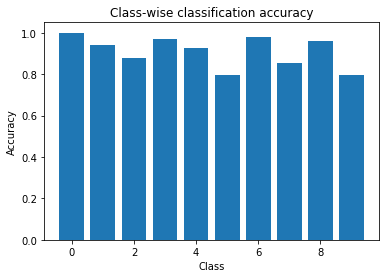

In [19]:
plt.bar([0,1,2,3,4,5,6,7,8,9],class_acc)
plt.xlabel('Class')
plt.ylabel('Accuracy')
plt.title('Class-wise classification accuracy')
plt.show()

<Figure size 432x288 with 0 Axes>

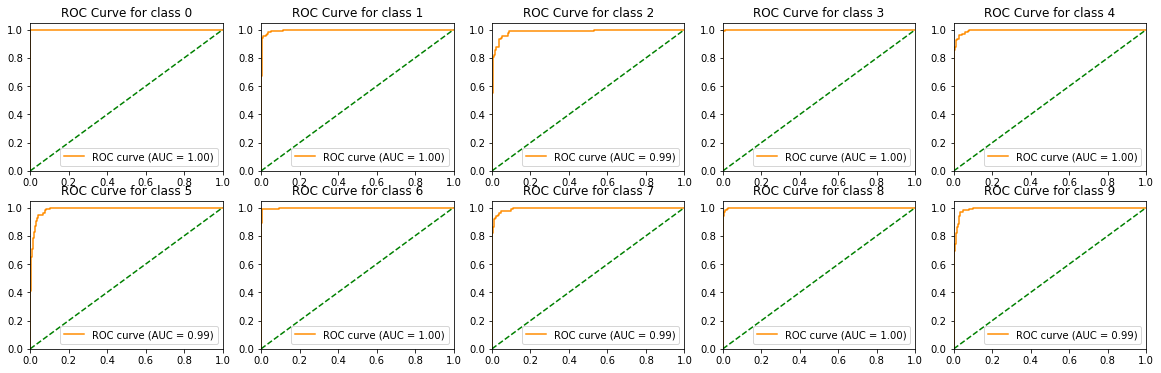

In [20]:
#d. Plot the classification ROC and AUC curves for each class.
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range (10) :
    fpr[i], tpr[i], _= roc_curve(onehot_ytest[:, i], predictions[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
plt.figure()
fig, axs = plt.subplots(2, 5, figsize=(20, 6))
for i, ax in zip(range(10), axs.ravel()):
    ax.plot(fpr[i],tpr[i],color='darkorange',label= 'ROC curve (AUC = %0.2f)' % roc_auc[i])
    ax.plot([0, 1], [0, 1], 'g--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_title('ROC Curve for class {}'. format(i))
    ax.legend(loc= "lower right")

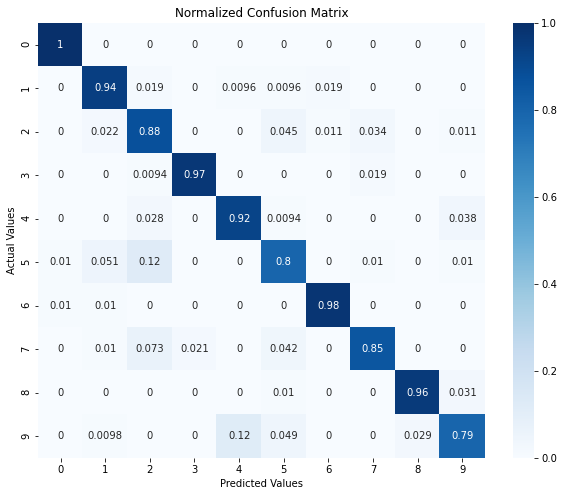

In [21]:
#e. Plot the normalized confusion matrix.
conf_matrix= confusion_matrix(ytest, ypred, normalize= 'true')
plt.figure(figsize = (10,8))
ax = sns.heatmap(conf_matrix, annot=True, cmap='Blues')
ax.set_title('Normalized Confusion Matrix')
ax.set_xlabel('Predicted Values')
ax.set_ylabel('Actual Values')
plt.show()

In [22]:
#f. Precision, Recall, and F-1 score on the test set.
from sklearn.metrics import precision_score, recall_score, f1_score
precision = precision_score(ytest, ypred, average='weighted')
recall = recall_score(ytest, ypred, average='weighted')
f1 = f1_score(ytest, ypred, average='weighted')
print('Test set precision score is {},recall score is {},f1 score is {}'.format(precision,recall,f1))
##

Test set precision score is 0.9129461946834612,recall score is 0.911,f1 score is 0.9109505707641552


Q: Show  some  examples  of  the  success/failure  cases  of  the  model.  Among  which  two 
classes  misclassification  happens  the  most?  Provide  your  insights  and  support  your 
answers with analytic reasons.

In [23]:
#separate success/failure cases
true_list = []
false_list = []
for i,j in zip(range(len(ypred)),(ypred == ytest)):
    if j == True:
        true_list.append(i)
    else:
        false_list.append(i)

In [24]:
import random
def get_example_cases(index_list,case_num):
    for i in range(case_num):
        index = random.choice(index_list)
        input = dataset['x_test'][index]
        #print('Correct digit: {}, Predicted digit:{}'.format(ytest[index],ypred[index]))
        
        plt.figure(figsize=(10,3))
        plt.subplot(1,3,1)
        plt.plot(dataset['templates']['x'][ytest[index]])
        plt.title('Correct Label Template, class'+str(ytest[index]))

        plt.subplot(1,3,2)
        plt.plot(input,'r')
        plt.title('Input array')
        
        plt.subplot(1,3,3)
        plt.plot(dataset['templates']['x'][ypred[index]])
        plt.title('Predicted Label Template, class'+str(ypred[index]))

5 examples of correct cases:


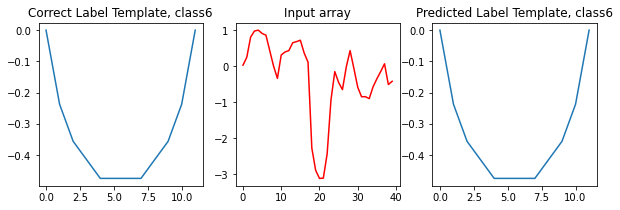

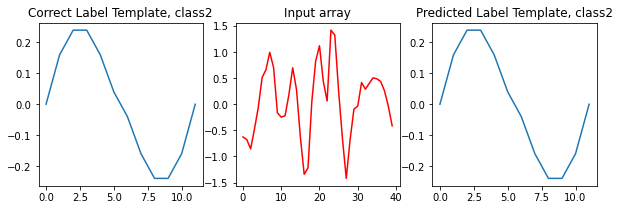

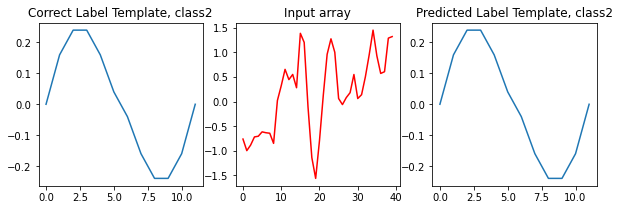

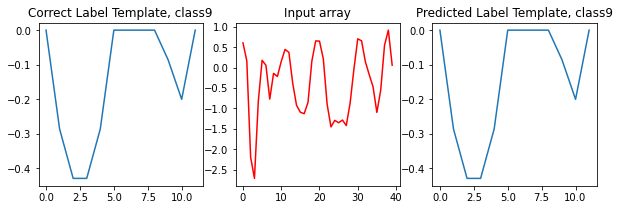

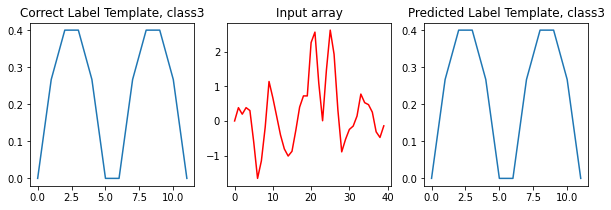

In [25]:
#Examples of success/failure cases
print('5 examples of correct cases:')
get_example_cases(true_list,5)

5 examples of failure cases:


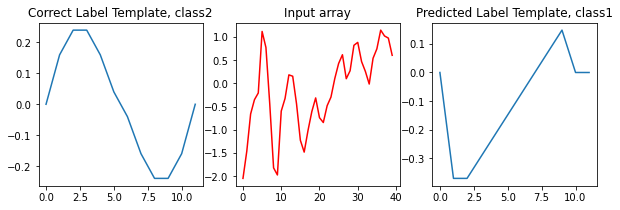

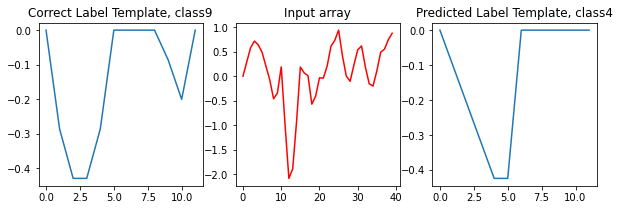

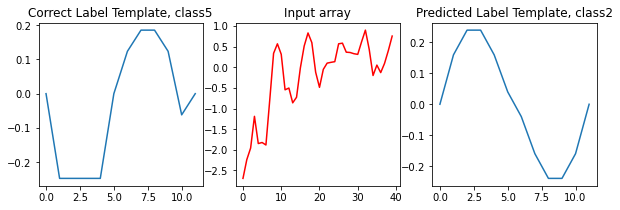

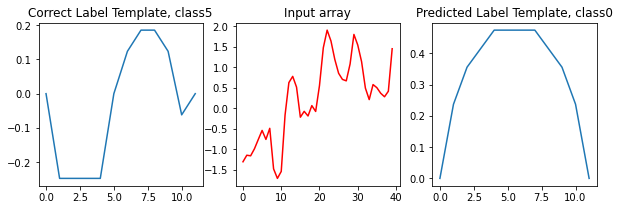

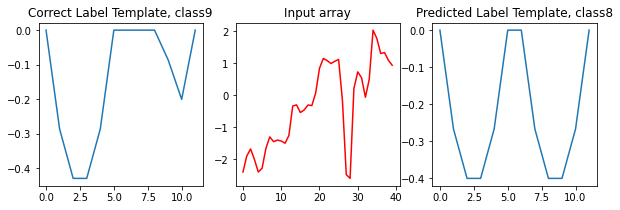

In [26]:
print('5 examples of failure cases:')
get_example_cases(false_list,5)

In [27]:
#list of all failure cases
failure_pred = []
for index in false_list:
    failure_pred.append(ypred[index])
#count the number of misclassifications in each class
count_dict = dict((x,failure_pred.count(x)) for x in set(failure_pred))
print("The number of misclassifications in each class",count_dict)
#get the most misclassified classes
most_mis_class = max(count_dict, key=count_dict.get)
print("The most misclassified classes is",most_mis_class)

The number of misclassifications in each class {0: 2, 1: 10, 2: 25, 3: 2, 4: 13, 5: 16, 6: 3, 7: 6, 8: 3, 9: 9}
The most misclassified classes is 2


In [28]:
#get the ytrue label list when predict class is 2 and find all misclassifications.
failure_class_2 = []
for i in ytest[np.where(ypred ==2)[0]]:
    if i !=2:
        failure_class_2.append(i)
#count the number of misclassifications of each class in class 2
count_class_2 = dict((x,failure_class_2.count(x)) for x in set(failure_class_2))
#find the pair of most misclassification classes
pair_class = max(count_class_2, key=count_class_2.get)
print("The misclassifications pair of class 2 is class {}".format(pair_class))

The misclassifications pair of class 2 is class 5


Among class 2 and class 5 misclassification happens the most.

# Explanation

In [29]:
from xai_utils import *

Take a test sample

In [30]:
x_test = dataset['x_test']
y_test = dataset['y_test']

Give the input to the model (Prediction)

In [31]:
index = int(np.floor(np.random.rand()*1000))
input = np.expand_dims(np.expand_dims(x_test[index], axis=0), axis=-1)
label = y_test[index]
print('Correct digit: '+str(label))
print('Predicted digit: '+str(np.argmax(model(np.expand_dims(np.expand_dims(x_test[index], axis=0), axis=-1)).numpy())))
print('Confidence score for the correct label: '+str(model(np.expand_dims(np.expand_dims(x_test[index], axis=0), axis=-1)).numpy()[0,label]))

Correct digit: 3
Predicted digit: 3
Confidence score for the correct label: 0.9999987


## Method 1: Grad-CAM

Input 0(Correct cases):
Correct digit: 0, Predicted digit: 0

Input 1(Correct cases):
Correct digit: 1, Predicted digit: 1

Input 2(Correct cases):
Correct digit: 2, Predicted digit: 2

Input 3(Correct cases):
Correct digit: 3, Predicted digit: 3

Input 4(Correct cases):
Correct digit: 4, Predicted digit: 4

Input 5(Correct cases):
Correct digit: 5, Predicted digit: 5

Input 6(Correct cases):
Correct digit: 6, Predicted digit: 6

Input 7(Correct cases):
Correct digit: 7, Predicted digit: 7

Input 8(Correct cases):
Correct digit: 8, Predicted digit: 8

Input 9(Correct cases):
Correct digit: 9, Predicted digit: 9



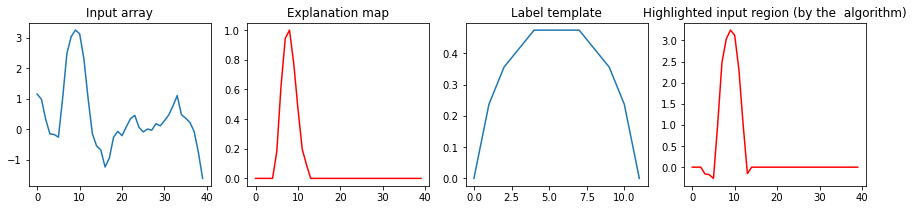

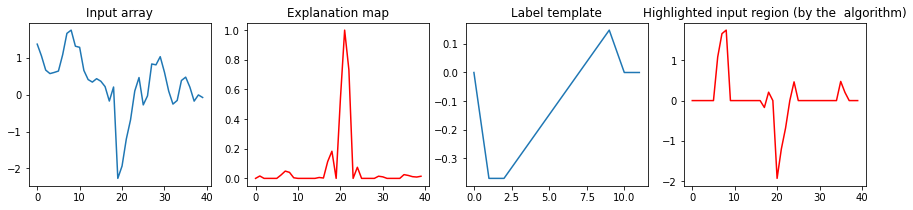

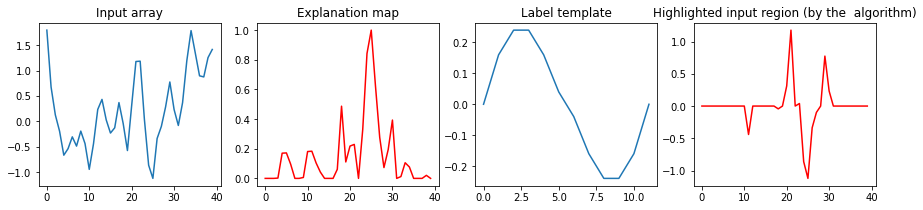

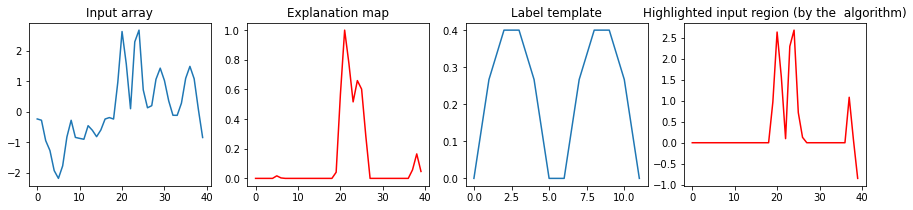

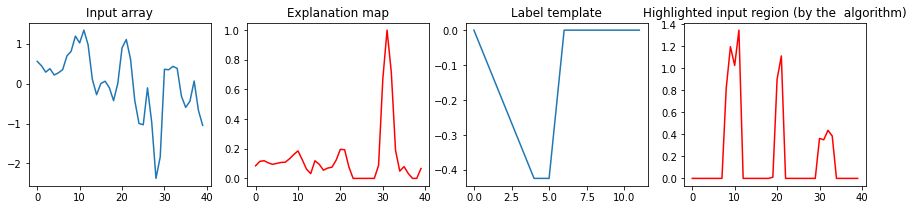

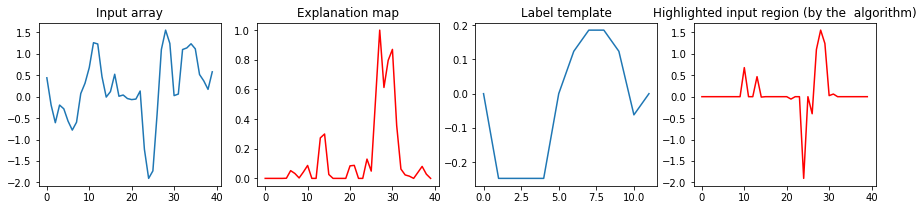

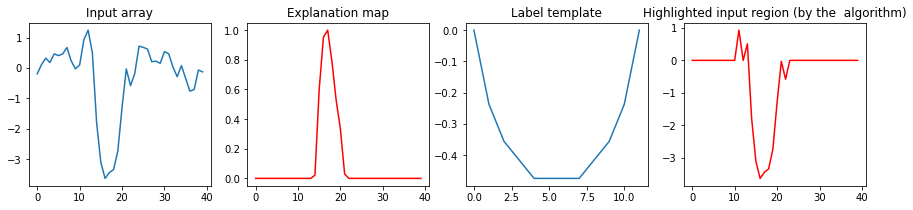

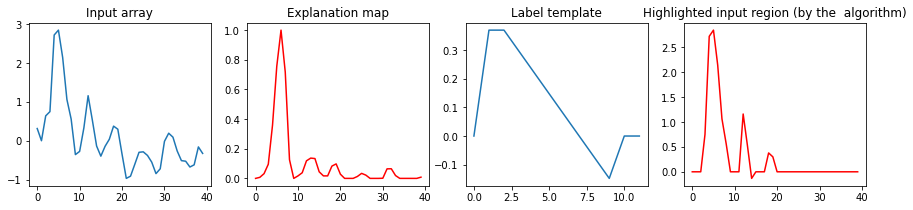

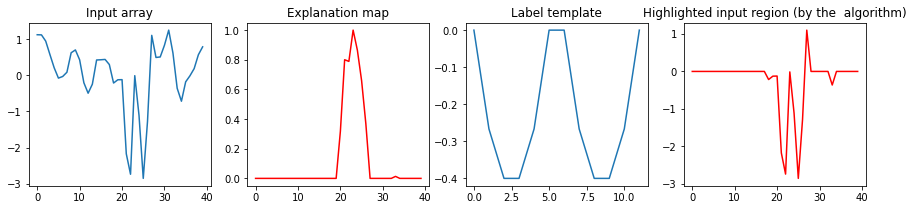

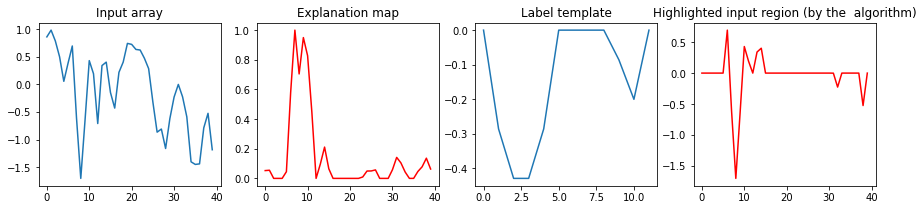

In [38]:
#random get one index in each class and create a list
index_list = []
count = 0
random.seed(1000)
for i in range(10): 
    index_list.append(random.choice(np.where(dataset['y_test']==i)[0]))
#Explanation map for each class
for index in index_list:
    input = np.expand_dims(np.expand_dims(x_test[index], axis=0), axis=-1)
    label = y_test[index]
    explanation = grad_cam(model, input, 'conv1d_2')
    threshold = np.sort(explanation)[-12]
    plt.figure(figsize=(15,3))
    plt.subplot(1,4,1)
    plt.plot(input[0])
    plt.title('Input array')

    plt.subplot(1,4,2)
    plt.plot(explanation, 'r')
    plt.title('Explanation map')

    plt.subplot(1,4,3)
    plt.plot(dataset['templates']['x'][label])
    plt.title('Label template')

    plt.subplot(1,4,4)
    plt.plot((input[0,:,0]*(explanation>threshold)), 'r')
    plt.title('Highlighted input region (by the  algorithm)')
    
    if label == np.argmax(model(input).numpy()):
        print('Input {}({}):'.format(count,'Correct cases'))
    else:
        print('Input {}({}):'.format(count,'Failure cases'))
    print('Correct digit: '+str(label)+', Predicted digit: '+str(np.argmax(model(input).numpy())))
    print('')
    count+=1

## Method 2: LIME

In [41]:
from lime.lime_tabular import LimeTabularExplainer
from scipy.signal import savgol_filter

In [46]:
def LIME_1d(inp,training_set = x_test, training_label = y_test,model = model,num_samples=150,num_features=10):
    a = LimeTabularExplainer(training_set,training_labels=training_label)
    exp = a.explain_instance(inp, model.predict, num_samples=num_samples ,num_features=num_features)
    mask = np.zeros(inp.shape)
    for i, j in exp.as_map()[1]:
        mask[i] = inp[i]
    return mask

Input 0(Correct cases):
Correct digit: 0, Predicted digit: 0

Input 1(Correct cases):
Correct digit: 1, Predicted digit: 1

Input 2(Correct cases):
Correct digit: 2, Predicted digit: 2

Input 3(Correct cases):
Correct digit: 3, Predicted digit: 3

Input 4(Correct cases):
Correct digit: 4, Predicted digit: 4

Input 5(Correct cases):
Correct digit: 5, Predicted digit: 5

Input 6(Correct cases):
Correct digit: 6, Predicted digit: 6

Input 7(Correct cases):
Correct digit: 7, Predicted digit: 7

Input 8(Correct cases):
Correct digit: 8, Predicted digit: 8

Input 9(Correct cases):
Correct digit: 9, Predicted digit: 9



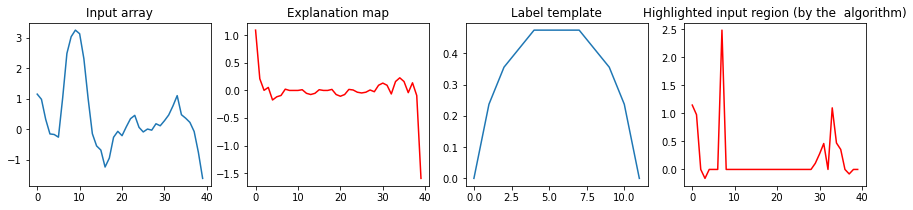

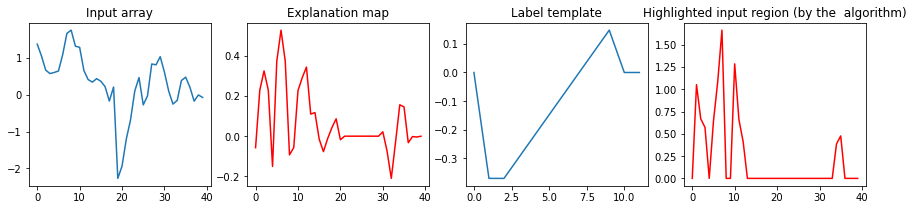

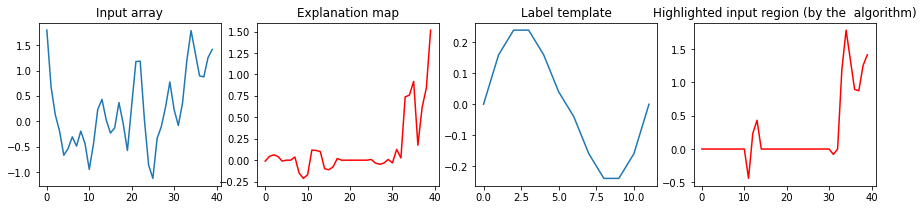

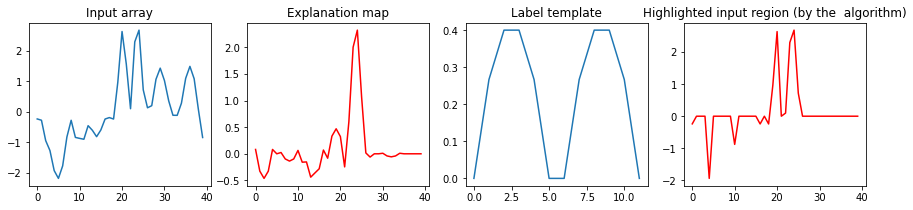

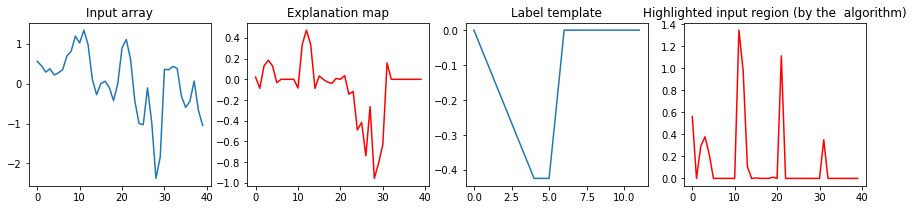

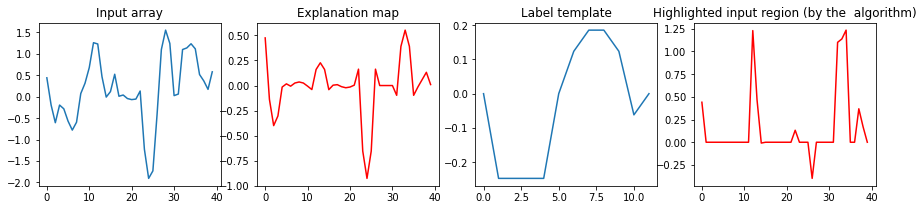

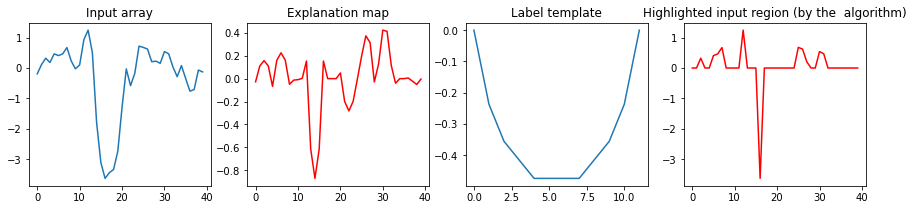

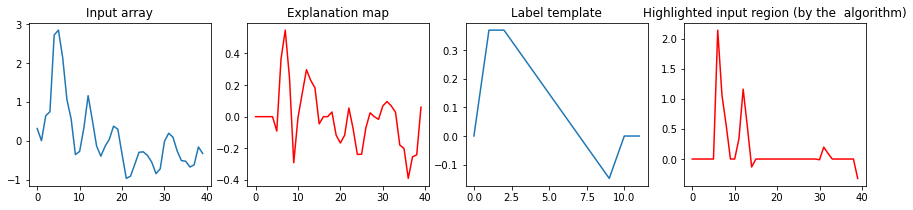

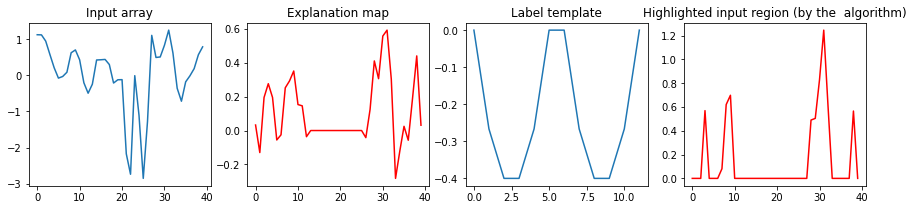

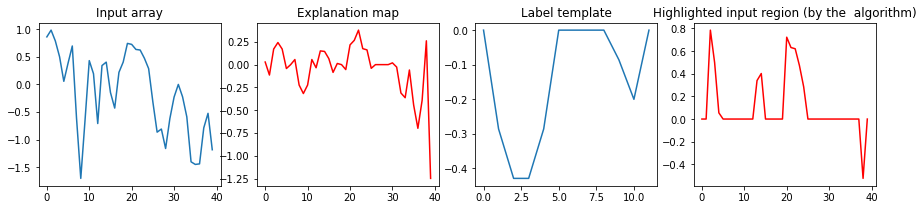

In [47]:
#random get one index in each class and create a list
index_list = []
count = 0
random.seed(1000)
for i in range(10): 
    index_list.append(random.choice(np.where(dataset['y_test']==i)[0]))
#Explanation map for each class
for index in index_list:
    input = np.expand_dims(np.expand_dims(x_test[index], axis=0), axis=-1)
    label = y_test[index]
    explanation = LIME_1d(x_test[index],training_set = x_test, training_label = y_test,model = model, num_features=10)
    explanation = savgol_filter(explanation,5,3)
    threshold = np.sort(explanation)[-12]
    plt.figure(figsize=(15,3))
    plt.subplot(1,4,1)
    plt.plot(input[0])
    plt.title('Input array')

    plt.subplot(1,4,2)
    plt.plot(explanation, 'r')
    plt.title('Explanation map')

    plt.subplot(1,4,3)
    plt.plot(dataset['templates']['x'][label])
    plt.title('Label template')

    plt.subplot(1,4,4)
    plt.plot((input[0,:,0]*(explanation>threshold)), 'r')
    plt.title('Highlighted input region (by the  algorithm)')
    
    if label == np.argmax(model(input).numpy()):
        print('Input {}({}):'.format(count,'Correct cases'))
    else:
        print('Input {}({}):'.format(count,'Failure cases'))
    print('Correct digit: '+str(label)+', Predicted digit: '+str(np.argmax(model(input).numpy())))
    print('')
    count+=1

## Method 3: IG(Integrated Gradients)

In [32]:
def IG(inp, label = None, step = range(50), model = model):
    t_input = tf.convert_to_tensor([inp])
    baseline = np.zeros(inp.shape)
    path_inputs = np.asarray([baseline + (i/(step[-1]+1))*(inp-baseline) for i in step])
    with tf.GradientTape() as tape:
        inputs = tf.cast(path_inputs, tf.float32)
        tape.watch(inputs)
        predictions = model(inputs)
        loss = predictions[:, label]

    grads = tape.gradient(loss, inputs)
    grads = (grads[:-1] + grads[1:]) / 2.0
    integrated_gradients = (inp-baseline)*np.average(grads, axis=0)
    return integrated_gradients

Input 0(Correct cases):
Correct digit: 0, Predicted digit: 0

Input 1(Correct cases):
Correct digit: 1, Predicted digit: 1

Input 2(Correct cases):
Correct digit: 2, Predicted digit: 2

Input 3(Correct cases):
Correct digit: 3, Predicted digit: 3

Input 4(Correct cases):
Correct digit: 4, Predicted digit: 4

Input 5(Correct cases):
Correct digit: 5, Predicted digit: 5

Input 6(Correct cases):
Correct digit: 6, Predicted digit: 6

Input 7(Correct cases):
Correct digit: 7, Predicted digit: 7

Input 8(Correct cases):
Correct digit: 8, Predicted digit: 8

Input 9(Correct cases):
Correct digit: 9, Predicted digit: 9



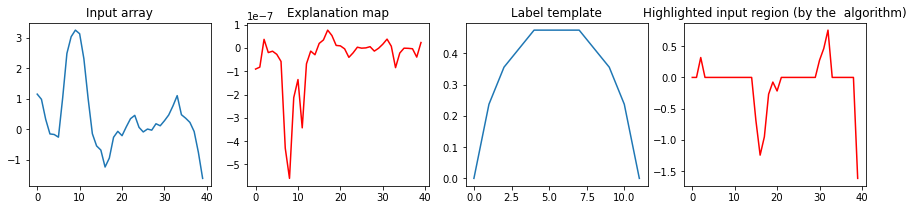

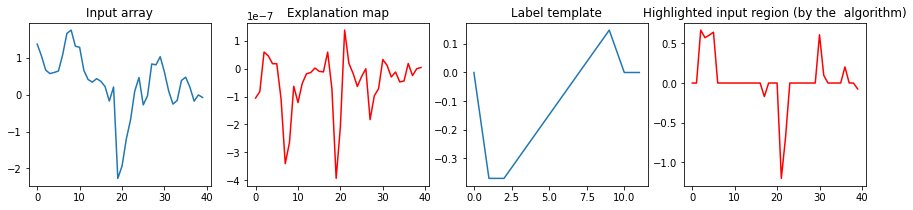

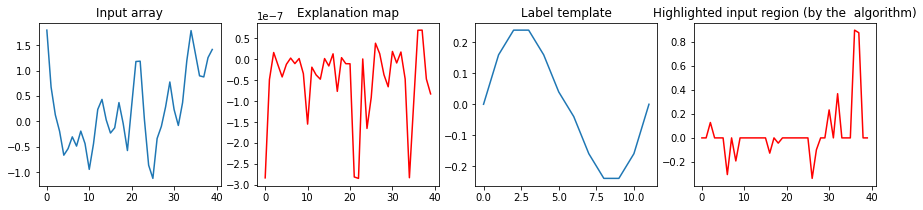

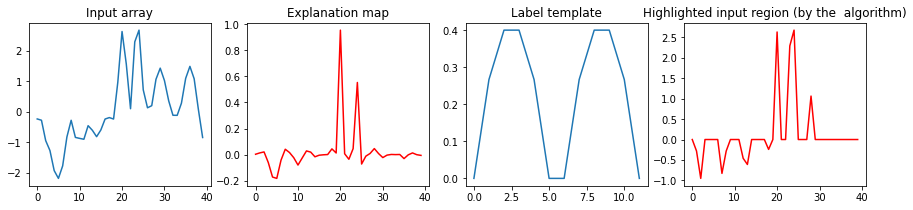

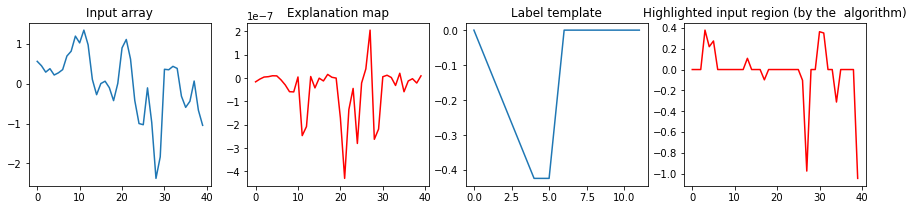

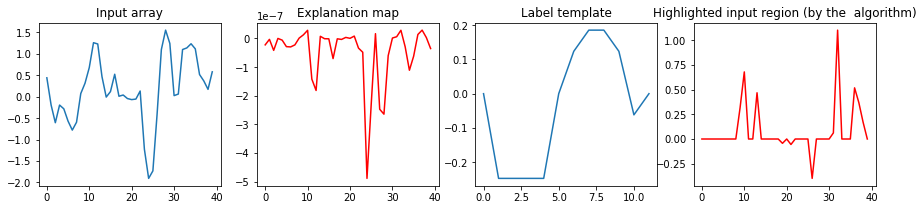

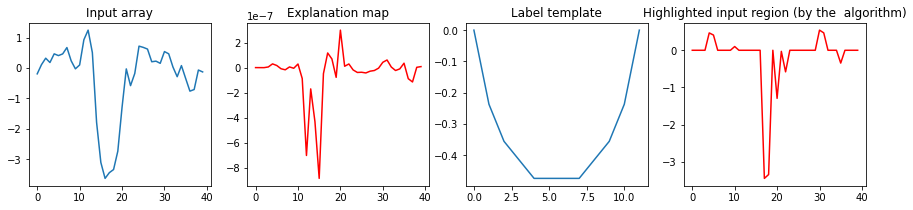

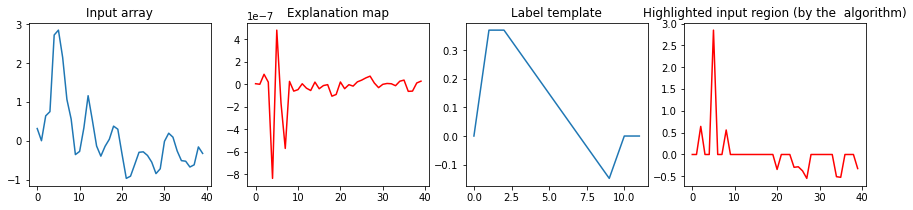

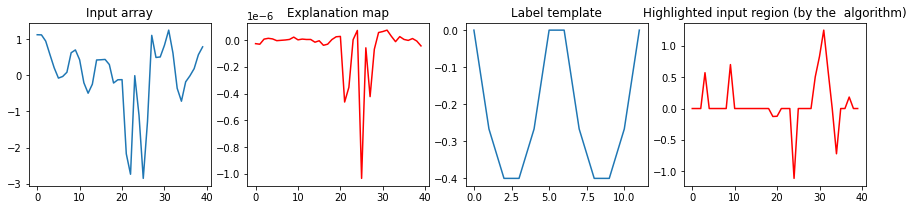

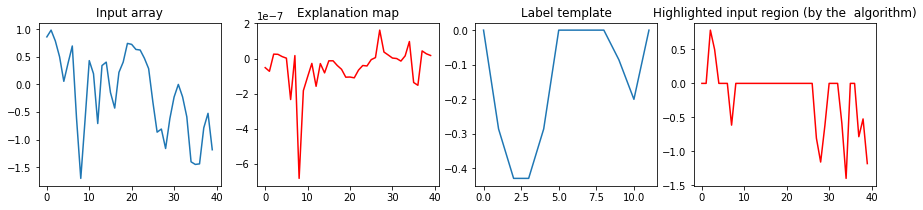

In [39]:
#random get one index in each class and create a list
index_list = []
count = 0
random.seed(1000)
for i in range(10): 
    index_list.append(random.choice(np.where(dataset['y_test']==i)[0]))
#Explanation map for each class
for index in index_list:
    input = np.expand_dims(np.expand_dims(x_test[index], axis=0), axis=-1)
    label = y_test[index]
    explanation = IG(input.flatten(),3)
    threshold = np.sort(explanation)[-12]
    plt.figure(figsize=(15,3))
    plt.subplot(1,4,1)
    plt.plot(input[0])
    plt.title('Input array')

    plt.subplot(1,4,2)
    plt.plot(explanation, 'r')
    plt.title('Explanation map')

    plt.subplot(1,4,3)
    plt.plot(dataset['templates']['x'][label])
    plt.title('Label template')

    plt.subplot(1,4,4)
    plt.plot((input[0,:,0]*(explanation>threshold)), 'r')
    plt.title('Highlighted input region (by the  algorithm)')
    
    if label == np.argmax(model(input).numpy()):
        print('Input {}({}):'.format(count,'Correct cases'))
    else:
        print('Input {}({}):'.format(count,'Failure cases'))
    print('Correct digit: '+str(label)+', Predicted digit: '+str(np.argmax(model(input).numpy())))
    print('')
    count+=1

## Quantitative evaluation

In [34]:
def calculate_drop_increase(images, model, exmap, class_index, frac=0.15):
    '''
    inputs:
        images: a 4-D image of size (1 x H x W x 3)
          containing an image in RGB format and of size (H x W)
        model: The base model
        exmap: a given explanation map whose completeness is to be evaluated.
        class_index: The class to whom the explanation map is related to.
        frac: The fraction of top pixels selected.
    returns:v
        a tuple with 4 calculates values:
        (drop, increase, original_pred, eplanation_pred)
        drop (float): drop rate (between 0 and 1)
        increase (boolean): "1" if increase happened
        original_pred: confidence score for original image
        explanation_pred:  confidence score for the selected top pixels of the image.
    '''
    predictions = model.predict(images)
    #print(images.shape)
    # Pre-processing image 
    img=images[0,:,:]
    #img=img_to_array(img)
    img = np.expand_dims(img,axis=0)
    # Getting the prediction for image
    Y=predictions[0][class_index]
    
    grad_array=np.reshape(exmap, (-1,))
    array_size=int(grad_array.shape[0]*frac)
    thr=np.flip(sorted(grad_array))[array_size]
    exmap1_msk=(exmap>thr)
    exmap1_thr=np.zeros(shape=(1,40,1))
    exmap1_thr[0,:,0]=img[0,:,0]*exmap1_msk ## Explanation map
    ex_predictions = model.predict(exmap1_thr)[0]
    O1=ex_predictions[class_index]
    etta=(Y-O1)/(Y+1e-100)
    return (etta*(etta>0), 1*(etta<0), Y, O1)

## Grad-CAM

In [55]:
drop_rate = 0.
increase_rate = 0.
for i in range(1000):
    test_input = np.expand_dims(x_test[i], axis=0)
    test_predict_out = np.argmax(model.predict(test_input), axis=-1)
    explanation = grad_cam(model, input, 'conv1d_2')
    drop_rate += calculate_drop_increase(input, model, explanation, class_index=test_predict_out, frac=0.3)[0]
    increase_rate += calculate_drop_increase(input, model, explanation, class_index=test_predict_out, frac=0.3)[1]
drop_rate = drop_rate / 1000
increase_rate = increase_rate / 1000

In [56]:
print('Grad-CAM method: Drop rate is {} and increase rate is {}'.format(drop_rate,increase_rate))

Grad-CAM method: Drop rate is [0.19135013] and increase rate is [0.614]


## LIME

In [48]:
drop_rate = 0.
increase_rate = 0.
for index in range(1000):
    test_input = np.expand_dims(x_test[index], axis=0)
    test_predict_out = np.argmax(model.predict(test_input), axis=-1)
    explanation = LIME_1d(x_test[index],training_set = x_test, training_label = y_test,model = model, num_features=10)
    explanation = savgol_filter(explanation,5,3)
    drop_rate += calculate_drop_increase(input, model, explanation, class_index=test_predict_out, frac=0.3)[0]
    increase_rate += calculate_drop_increase(input, model, explanation, class_index=test_predict_out, frac=0.3)[1]
drop_rate = drop_rate / 1000
increase_rate = increase_rate / 1000

In [50]:
print('LIME method: Drop rate is {} and increase rate is {}'.format(drop_rate,increase_rate))

LIME method: Drop rate is [0.19551384] and increase rate is [0.774]


# IG(Integrated Gradients)

In [53]:
drop_rate = 0.
increase_rate = 0.
for index in range(1000):
    prediction=model(np.expand_dims(np.expand_dims(x_test[index], axis=0), axis=-1)).numpy()
    explanation_map_IG = IG(np.expand_dims(x_test[index], axis=-1), label=np.argmax(prediction[0])).flatten()
    drop_rate += calculate_drop_increase(np.expand_dims(np.expand_dims(x_test[index], axis=0), axis=-1), model, explanation_map_IG, class_index=np.argmax(prediction[0]), frac=0.3)[0]
    increase_rate += calculate_drop_increase(np.expand_dims(np.expand_dims(x_test[index], axis=0), axis=-1), model, explanation_map_IG, class_index=np.argmax(prediction[0]), frac=0.3)[1]
drop_rate /= 1000
increase_rate /= 1000

In [54]:
print('Integrated Gradients method: Drop rate is {} and increase rate is {}'.format(drop_rate,increase_rate))

Integrated Gradients method: Drop rate is 0.29191747749522484 and increase rate is 0.349
